In [1]:
import os

import click
from h5py._hl import base
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter, LogFormatterExponent, LogLocator
from matplotlib import cm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import numpy as np
import pandas as pd

import bioframe
import cooler
import cooltools.lib.plotting
import cooltools.snipping
from cooltools import snipping

In [14]:
def format_chrom_labels(ax, chrom_names, chrom_positions, centromeres, label_bar_pad=7, plot_labels=True):
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    x_trans = ax.get_xaxis_transform()
    y_trans = ax.get_yaxis_transform()

    cmap = cm.summer(np.linspace(0, 1, len(chrom_names) * 2))

    for i, (chrom, (start, end)) in enumerate(zip(chrom_names, chrom_positions)):
        if plot_labels:
            # plot axis labels
            ax.annotate(chrom, xy=((start + end) // 2, 1.037), xycoords=x_trans, ha='center', va='bottom')
            ax.annotate(chrom, xy=(-0.037, (start + end) // 2), xycoords=y_trans, ha='right', va='center', rotation=90)

        # plot label bars
        ax.plot([start + label_bar_pad, end - label_bar_pad], [1.02, 1.02], color=cmap[i], transform=x_trans, lw=7, clip_on=False)
        ax.plot([-0.02, -0.02], [start + label_bar_pad, end - label_bar_pad], color=cmap[i], transform=y_trans, lw=7, clip_on=False)

        # plot centromere positions
        ax.plot(start + centromeres[chrom], 1.02, transform=x_trans, color='black', marker='o', markersize=6, clip_on=False)
        ax.plot(-0.02, start + centromeres[chrom], transform=y_trans, color='black', marker='o', markersize=6, clip_on=False)


def format_ticks(ax, x=True, y=True, rotate=True, unit='b', bin_size=1):
    if unit == 'b':
        div = 1
    elif unit == 'kb':
        div = 1000
    elif unit == 'Mb':
        div = 100_000

    bp_formatter = FuncFormatter(lambda x, pos: f'{int(x * bin_size // div)} {unit}')
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    else:
        ax.yaxis.set_ticks([])
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    else:
        ax.xaxis.set_ticks([])
    if rotate:
        ax.tick_params(axis='x',rotation=45)

def get_contact_map(clr, balanced, start=None, end=None):
    if start is None or end is None:
        return clr.matrix(balance=balanced)[:]
    else:
        return clr.matrix(balance=balanced)[start:end, start:end]


def get_centromeres(centromeres_path, assembly):
    if centromeres_path:
        centromeres = pd.read_csv(centromeres_path, delim_whitespace=True, header=None, names=['chrom', 'start', 'end', 'mid'])
        centromeres['mid'] = centromeres.apply(lambda row: (row['start'] + row['end']) // 2, axis=1)
    else:
        centromeres = bioframe.fetch_centromeres(assembly)

    return centromeres


def get_chromsizes(assembly):
    return bioframe.fetch_chromsizes(assembly, filter_chroms=False, as_bed=True)


def open_cooler(path, resolution):
    ext = os.path.splitext(path)[1]
    if ext == '.cool':
        return cooler.Cooler(path)
    elif ext == '.mcool':
        return cooler.Cooler('::/resolutions/'.join((path, str(resolution))))
    else:
        raise TypeError('Provided file is not of required .cool or .mcool type.')

In [8]:
def snip_pileup(clr, resolution, features, chromsizes, flank):
    windows = snipping.make_bin_aligned_windows(
        resolution,
        features['chrom'],
        features['mid'],
        flank_bp=flank
    )
    supports = chromsizes[['chrom', 'start', 'end']].values
    windows = snipping.assign_regions(windows, supports)

    snipper = cooltools.snipping.CoolerSnipper(clr)
    stack = cooltools.snipping.pileup(
        windows,
        snipper.select,
        snipper.snip
    )
    stack = np.nanmean(stack, axis=2)

    return stack

In [62]:
file_path = '/groups/goloborodko/projects/lab/baxterLab2020/results/distiller/coolers_library/200828_HiC_574_cdc20tdtop2tdscc173_cdc20_1b_nextseq.sacCer3.mapq_30.1000.mcool'
file_paths = [
    '/groups/goloborodko/projects/lab/baxterLab2020/results/distiller/coolers_library/200828_HiC_574_cdc20tdtop2tdscc173_cdc20_1b_nextseq.sacCer3.mapq_30.1000.mcool',
    '/groups/goloborodko/projects/lab/baxterLab2020/results/distiller/coolers_library/190425_HiC_938_cdc20td_cdc20_1b_nextseq.sacCer3.mapq_30.1000.mcool'
]
cens_path = '/groups/goloborodko/genomepy/sacCer3/sacCer3.centromeres'
out_path = '/users/emma.rusch/hiC/out/maps/pileup_test.png'
resolution = 1000
exclude_chroms = ['chrM']
region='centromere'
window_size = 200_000
font_size = 18
title = 'cdc20-td top2-td scc1-73'
ratio = False

In [63]:
centromeres = get_centromeres(cens_path, 'sacCer3')
chromsizes = get_chromsizes('sacCer3')
chromsizes = chromsizes[~chromsizes.chrom.isin(exclude_chroms)]

clr = open_cooler(file_path, resolution)

In [64]:
flank = window_size // 2
stacks = snip_pileup(clr, resolution, centromeres, chromsizes, flank)

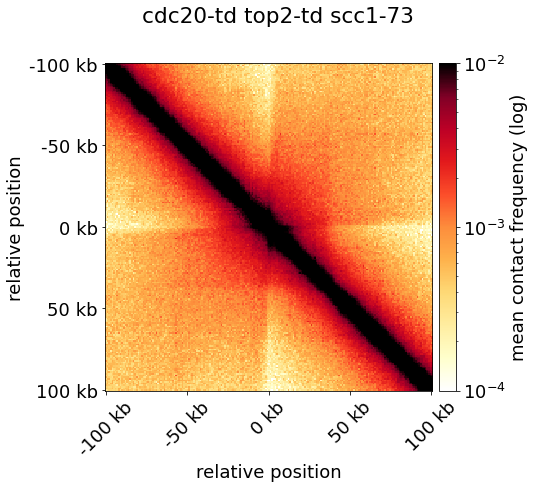

In [75]:
font = {'size': font_size}
plt.rc('font', **font)

fig, ax = plt.subplots(
    figsize=(7, 7),
    ncols=1
)

start = 0
end = window_size

if ratio:
    vmin = 0.1
    vmax = 10
    colormap = 'RdBu_r'
    cbar_label = 'ratio means (log)'
else:
    vmin = 0.0001
    vmax = 0.01
    colormap = 'fall'
    cbar_label = 'mean contact frequency (log)'

im = ax.matshow(
    stacks,
    norm=LogNorm(vmin=vmin, vmax=vmax),
    cmap=colormap
)

ax.set_xlabel('relative position')
ax.set_ylabel('relative position')

ticks_px = np.linspace(0, flank * 2 // resolution, 5)
ticks_kbp = ((ticks_px - ticks_px[-1] / 2) * resolution // 1000).astype(int)
ticks_kbp = [f'{pos} kb' for pos in ticks_kbp]
ax.xaxis.set_ticks(ticks_px)
ax.xaxis.set_ticklabels(ticks_kbp)
ax.yaxis.set_ticks(ticks_px)
ax.yaxis.set_ticklabels(ticks_kbp)
ax.xaxis.tick_bottom()
ax.tick_params(axis='x', rotation=45)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label=cbar_label)

fig.suptitle(title)
fig.subplots_adjust(top=0.5)

plt.tight_layout()
#plt.savefig(out_path, dpi=300, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

In [68]:
ticks_px

array([  0.,  50., 100., 150., 200.])